<a href="https://colab.research.google.com/github/dsivov/netIndex/blob/master/laticceIndex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install -q tensorflow-lattice

In [0]:
import numpy
import random
import string
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from absl import app
from absl import flags

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorflow_lattice as tfl
from matplotlib import pyplot


FLAGS = flags.FLAGS
flags_dict = FLAGS._flags()    
keys_list = [keys for keys in flags_dict]    
for keys in keys_list: 
  FLAGS.__delattr__(keys)
  FLAGS = flags.FLAGS
flags.DEFINE_integer('num_epochs', 200, 'Number of training epoch.')


Generate 4-char string and put it into numpy. Target is position

In [0]:
keys = numpy.empty((0,5), float)

keys_list=[]
for i in range(1000):
    keys_list.append(''.join(random.choices(string.ascii_uppercase +
                                 string.digits + string.ascii_lowercase, k=4)))
    
keys_list.sort()
print(keys_list)

for i in range(1000):
    key = keys_list[i]
    key_array = [ord(c)/255 for c in key]
    # add position 
    key_array.append(i/1000)
    print (key_array)
    keys = numpy.append(keys, numpy.array([key_array]), axis=0)

   

['01Xk', '05aJ', '05tk', '06nr', '073b', '0E9U', '0I7K', '0KC5', '0KUN', '0TUt', '0URs', '0gmX', '0igz', '0u9Z', '0w7p', '0yFA', '0yp2', '0zpj', '10N4', '11S8', '12Fy', '16hl', '193y', '19jI', '1Bni', '1CbZ', '1Drw', '1EQt', '1KV7', '1Ouu', '1RFk', '1RaU', '1SyW', '1U51', '1fHc', '1fVx', '1hdS', '1iB5', '1kOA', '1lb6', '1vBl', '1xqy', '20CJ', '22FZ', '2C74', '2Cg0', '2Dl2', '2Ecx', '2HU2', '2JxO', '2KDt', '2Mm7', '2PqF', '2aj7', '2dL3', '2n9r', '2wbr', '2zP0', '2zSU', '36qv', '3AuH', '3Lbd', '3LrX', '3MGw', '3NC6', '3QNn', '3QkZ', '3Uyx', '3VX5', '3aI6', '3akq', '3otQ', '3pvb', '3qUW', '3qW2', '3srG', '3vxr', '3weF', '3xU9', '43CO', '47wS', '48I8', '48Vp', '4Bko', '4Hzu', '4I4t', '4Knz', '4XhE', '4h0T', '4i0z', '4nQQ', '4tF3', '4tvg', '4uEU', '4uxC', '50fE', '55cf', '55lM', '5a01', '5aCF', '5bX5', '5fMY', '5hW0', '5jY9', '5k3j', '5pwr', '5tLv', '5xmf', '60J9', '63ae', '68AQ', '6LWM', '6MrG', '6Nc1', '6Olv', '6Qjo', '6RRH', '6ReC', '6TxY', '6XFU', '6d8u', '6jjl', '6kta', '6mNU', '6tLQ',

Create data frame

In [0]:
df = pd.DataFrame(data=keys, columns=["X1", "X2","X3","X4","target"])
print(df)
combined_calibrators = tfl.layers.ParallelCombination()
lattice_sizes = [2, 2, 2, 2]

           X1        X2        X3        X4  target
0    0.188235  0.192157  0.345098  0.419608   0.000
1    0.188235  0.207843  0.380392  0.290196   0.001
2    0.188235  0.207843  0.454902  0.419608   0.002
3    0.188235  0.211765  0.431373  0.447059   0.003
4    0.188235  0.215686  0.200000  0.384314   0.004
..        ...       ...       ...       ...     ...
995  0.478431  0.411765  0.274510  0.309804   0.995
996  0.478431  0.431373  0.462745  0.458824   0.996
997  0.478431  0.435294  0.352941  0.325490   0.997
998  0.478431  0.435294  0.411765  0.223529   0.998
999  0.478431  0.466667  0.215686  0.450980   0.999

[1000 rows x 5 columns]


Define "monotonicy" on each X, from 0 to 1

In [0]:
calibrator = tfl.layers.PWLCalibration(
 
input_keypoints=np.linspace(df['X1'].min(),
                                  df['X1'].max(),
                                  num=10),
dtype=tf.float32,     
output_min=0.0,
output_max=lattice_sizes[0] - 1.0,
kernel_initializer='equal_slopes',
monotonicity='increasing')
combined_calibrators.append(calibrator)

In [0]:
calibrator = tfl.layers.PWLCalibration(
 
input_keypoints=np.linspace(df['X2'].min(),
                                  df['X2'].max(),
                                  num=10),
    
dtype=tf.float32,     
output_min=0.0,
output_max=lattice_sizes[0] - 1.0,
kernel_initializer='equal_slopes',
monotonicity='increasing')
combined_calibrators.append(calibrator)

In [0]:
calibrator = tfl.layers.PWLCalibration(
 
input_keypoints=np.linspace(df['X3'].min(),
                                  df['X3'].max(),
                                  num=10),
    
dtype=tf.float32,     
output_min=0.0,
output_max=lattice_sizes[0] - 1.0,
kernel_initializer='equal_slopes',
monotonicity='increasing')
combined_calibrators.append(calibrator)

In [0]:
calibrator = tfl.layers.PWLCalibration(
 
input_keypoints=np.linspace(df['X4'].min(),
                                  df['X4'].max(),
                                  num=10),
    
dtype=tf.float32,     
output_min=0.0,
output_max=lattice_sizes[0] - 1.0,
kernel_initializer='equal_slopes',
monotonicity='increasing')
combined_calibrators.append(calibrator)

Laticce model

In [0]:

lattice = tfl.layers.Lattice(
      lattice_sizes=lattice_sizes,
      monotonicities=['increasing','increasing', 'increasing',
                      'increasing'],
      output_min=0.0,
      output_max=1.0)

In [0]:
model = keras.models.Sequential()
model.add(combined_calibrators)
model.add(lattice)
model.compile(loss=keras.losses.mean_squared_error,
                optimizer=keras.optimizers.Adagrad(learning_rate=1.0))

features = df[['X1', 'X2', 'X3','X4']].values.astype(np.float32)
target = df[['target']].values.astype(np.float32)

model.fit(features,
  target,
  batch_size=200,
  epochs=100,
  validation_split=0.1,
  shuffle=False)


Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 998us/sample - loss: 0.0959 - val_loss: 0.1235
Epoch 2/100
900/900 [==============================] - 0s 41us/sample - loss: 0.0650 - val_loss: 0.1341
Epoch 3/100
900/900 [==============================] - 0s 31us/sample - loss: 0.1311 - val_loss: 0.2890
Epoch 4/100
900/900 [==============================] - 0s 29us/sample - loss: 0.0883 - val_loss: 0.2176
Epoch 5/100
900/900 [==============================] - 0s 29us/sample - loss: 0.0829 - val_loss: 0.2502
Epoch 6/100
900/900 [==============================] - 0s 27us/sample - loss: 0.0915 - val_loss: 0.2756
Epoch 7/100
900/900 [==============================] - 0s 27us/sample - loss: 0.0548 - val_loss: 0.0482
Epoch 8/100
900/900 [==============================] - 0s 26us/sample - loss: 0.0691 - val_loss: 0.0161
Epoch 9/100
900/900 [==============================] - 0s 32us/sample - loss: 0.0352 - val_loss: 0.0031
Epoch 10/100
900/

Predict for each string

In [0]:
weights = model.layers[1].get_weights()
print (weights)

[array([[0.06177449],
       [0.06490992],
       [0.06427807],
       [0.06498742],
       [0.10149898],
       [0.10267194],
       [0.10212661],
       [0.12571713],
       [0.99224466],
       [0.9954838 ],
       [0.99489754],
       [0.99588716],
       [0.9985608 ],
       [0.9988228 ],
       [0.9985608 ],
       [0.9988228 ]], dtype=float32)]


In [0]:
predictions = model.predict(features)
#print(target[:100])
#print(features[:100])
#print(predictions)

[[0.07613772]
 [0.0765021 ]
 [0.07791767]
 [0.08353156]
 [0.08234373]
 [0.08436825]
 [0.08464049]
 [0.08466545]
 [0.08843986]
 [0.08724961]
 [0.08710951]
 [0.10733901]
 [0.111105  ]
 [0.07918453]
 [0.08159816]
 [0.08360377]
 [0.08725788]
 [0.08693019]
 [0.0879297 ]
 [0.10442677]
 [0.10323377]
 [0.10659117]
 [0.10771519]
 [0.10699408]
 [0.11424761]
 [0.07924718]
 [0.07973458]
 [0.07982913]
 [0.07995452]
 [0.08163127]
 [0.08449283]
 [0.08452966]
 [0.0873194 ]
 [0.08765001]
 [0.09285167]
 [0.09235597]
 [0.0955191 ]
 [0.10488193]
 [0.10788158]
 [0.10498596]
 [0.08058217]
 [0.08116519]
 [0.08251405]
 [0.08248958]
 [0.08604611]
 [0.08546074]
 [0.08520836]
 [0.08673733]
 [0.08671396]
 [0.09053132]
 [0.08845156]
 [0.09313505]
 [0.09252694]
 [0.09354477]
 [0.09727345]
 [0.10713929]
 [0.08135685]
 [0.08283105]
 [0.08330573]
 [0.08751681]
 [0.08929975]
 [0.0899528 ]
 [0.09117828]
 [0.08966603]
 [0.09252999]
 [0.11381857]
 [0.11143696]
 [0.11364605]
 [0.0845558 ]
 [0.0845224 ]
 [0.09083897]
 [0.09

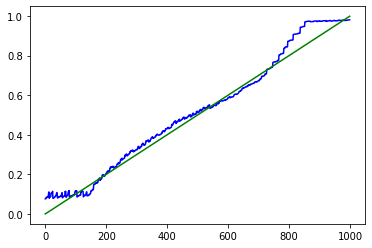

In [0]:
pyplot.plot(predictions, color="blue")
pyplot.plot(target, color="green")
#pyplot.plot(X_test, color="red")
pyplot.show()